In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.misc import derivative
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Utility functions

In [2]:
def get_data(place_name):
    """
    Reads a csv file containing 2 columns, date and cases.
    Adds a new column, days
    Returns a dataframe
    """
    filename = place_name + '.csv'
    df = pd.read_csv(filename, index_col=0)
    df['days'] = range(0, df.size)
    return df

#get_data('Hawaii')

In [3]:
def adjusted_r2(r2, n, p):
    """
    Adjusts an r-squared value to 
    r2: r squared
    n: number of data points
    p: number of parameters
    """
    return 1 - (1-r2)*(n-1)/(n-p-1)

## Model definitions

In [4]:
def exponential_model(t, N0, R):
    return N0*np.exp(R*t)

def linear_model(t, y_intercept, slope):
    return y_intercept + slope * t

# See https://www.kaggle.com/hotstaff/fitting-to-logistic-function-and-graph-drawing
def logistic_model(t, K, N0, R):
    return  (K / (1 + ((K-N0)/N0)*np.exp(-R*t)))

# The following parameters are used by scipy.optimize.curve_fit for bounds and initial values.
# They are stored in this dict so that they can be fine tuned for different places.
# The values correspond to model parameters:
#    logistic:    K, N0, R (K can be set to equal the place's population)
#    linear:      y_intercept, slope
#    exponential: N0, R

parameters = {
    'Guam':{
        'logistic_model': {
            'lower_bounds': [0, 0, 0.1],
            'upper_bounds': [168448, 100, 0.5],
            'initial': [10000, 1, 0.3]},   
        'linear_model':{
            'lower_bounds': [-100, 1],
            'upper_bounds': [100, 100],
            'initial': [1, 10]},
        'exponential_model': {
            'lower_bounds': [0, 0.1],
            'upper_bounds':[200, 0.5],
            'initial': [0.001, 0.3]}},           
    'Hawaii':{
        'logistic_model': {
            'lower_bounds': [0, 0, 0.1],
            'upper_bounds': [1412687, 100, 0.5],
            'initial': [10000, 1, 0.3]},   
        'linear_model':{
            'lower_bounds': [-200, 1],
            'upper_bounds': [200, 100],
            'initial': [1, 10]},
        'exponential_model': {
            'lower_bounds': [0, 0.1],
            'upper_bounds':[200, 0.5],
            'initial': [0.001, 0.3]}},
    'New York':{
        'logistic_model': {
            'lower_bounds': [0, 0, 0.1],
            'upper_bounds': [19450000, 100, 0.5],
            'initial': [10000, 1, 0.3]},   
        'linear_model':{
            'lower_bounds': [-1000000, 1],
            'upper_bounds': [100, 1000000],
            'initial': [1, 10]},
        'exponential_model': {
            'lower_bounds': [0.001, 0.1],
            'upper_bounds':[1000, 0.5],
            'initial': [0.001, 0.3]}}}           

## Curve fitter

In [5]:
def fit_curve(place_name, df, model, p0, bounds, extrapolated_days=0):

    # Do curve fit, but dump covariance into dummy variable
    p, _ = curve_fit(f=model, xdata=df.days, ydata=df.cases, p0=p0, bounds=bounds)
    
    # Calculate adjusted r-squared for fitted model
    targets = df.cases.values
    predictions = [model(day, *tuple(p)) for day in df.days]
    r2 = r2_score(targets, predictions)
    r2 = adjusted_r2(r2, df.shape[0], len(p0))
    
    # Calc x and y values for fitted curve (100 values between zero and max(days) plus extrapolated days
    x_smooth = np.linspace(0, max(df.days), 100)
    y_smooth = model(x_smooth, *tuple(p))
    
    # Calc x, y for extrapolation
    if extrapolated_days > 0:
        x = np.linspace(max(df.days), max(df.days)+extrapolated_days, 100)
        y = model(x, *tuple(p))
        plt.plot(x, y, marker='None', linestyle='dotted', color='black')

    # Plot everything together
    plt.bar(df.days, df.cases)
    plt.plot(x_smooth, y_smooth, marker='None', linestyle='-', color='black')
    #plt.plot(df.days, df.cases, marker='o', linestyle='none')

    # make plot title and Label axes
    if model == linear_model: 
        plt.title('{}\nLast data point: {} UTC\nLinear model\nn0={:.0f}, slope={:.2f}, fit={:.4f}'
            .format(place_name, df.index[-1], p[0], p[1], r2)),       
    if model == exponential_model: 
        plt.title('{}\nLast data point: {} UTC\nExponential model\nn0={:.0f}, r={:.2f}, fit={:.4f}'
            .format(place_name, df.index[-1], p[0], p[1], r2)),    
    if model == logistic_model: 
        plt.title('{}\nLast data point: {} UTC\nLogistic model\nn0={:.0f}, r={:.2f}, k={:.0f}, fit={:.4f}'
            .format(place_name, df.index[-1], p[1], p[2], p[0], r2))     
    plt.xlabel('days since 1st confirmed case({})'.format(df.index[0]))
    plt.ylabel('confirmed cases')
    plt.ylim(bottom=0)
    
    # Save plot to files
    plt.savefig('images/{}-{}-{}.png'.format(place_name, model.__name__, df.index[-1]), bbox_inches='tight')
    plt.savefig('images/{}-{}-latest.png'.format(place_name, model.__name__), bbox_inches='tight')
    
    plt.show()
    plt.close()   
    
    return

#fit_curve('Hawaii', df, logistic_model, logistic_init, logistic_bounds, 10)

## Plot logistic model derivative

In [6]:
def plot_logistic_model_derivative(place_name):
    df = get_data(place_name)
    model = logistic_model
    
    p0=parameters[place_name][model.__name__]['initial']

    # Do curve fit, but dump covariance into dummy variable
    p, _ = curve_fit(f=model,
                     xdata=df.days,
                     ydata=df.cases,
                     p0=p0,
                     bounds=[parameters[place_name][model.__name__]['lower_bounds'],
                             parameters[place_name][model.__name__]['upper_bounds']]) 

    # Calculate adjusted r-squared for fitted model
    targets = df.cases.values
    predictions = [model(day, *tuple(p)) for day in df.days]
    r2 = r2_score(targets, predictions)
    r2 = adjusted_r2(r2, df.shape[0], len(p0))

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    x = np.linspace(0, max(df.days)+10, 100)
    y = derivative(logistic_model, x, dx=0.001, args=p)
    ax1.plot(x, y)
    plt.title('{}\nLast data point: {} UTC\nLogistic model derivative\nn0={:.0f}, r={:.2f}, k={:.0f}, fit={:.4f}'
        .format(place_name, df.index[-1], p[1], p[2], p[0], r2)) 
    ax1.set_xlabel('days since 1st confirmed case({})'.format(df.index[0]))
    ax1.set_ylabel('confirmed cases');

    # Save plot to files
    plt.savefig('images/{}-logistic-model-derivative-{}.png'.format(place_name, df.index[-1]), bbox_inches='tight')
    plt.savefig('images/{}-logistic-model-derivative-latest.png'.format(place_name), bbox_inches='tight')
    
    plt.show()
    plt.close()
    
    return

# plot_logistic_model_derivative('Guam')

In [7]:
def logistic_model_predictions(place_name):
    """
    THIS NEEDS REVIEW.
    Generate logistic model results for day 15 onwards.
    """    
    df = get_data(place_name)
    first_case_date = df.index[0]
    model = logistic_model
    p0=parameters[place_name][model.__name__]['initial']
    results = {}
    for i in range(15, df.shape[0]):
        df_slice = df[:i+1]
        p, _ = curve_fit(f=model,
                         xdata=df_slice.days,
                         ydata=df_slice.cases,
                         p0=p0,
                         bounds=[parameters[place_name][model.__name__]['lower_bounds'],
                                 parameters[place_name][model.__name__]['upper_bounds']]) 
        
        # Calculate adjusted r-squared for fitted model
        targets = df_slice.cases
        predictions = [logistic_model(day, *tuple(p)) for day in df_slice.days]
        r2 = r2_score(targets, predictions)
        r2 = adjusted_r2(r2, df.shape[0], len(p0))

        results[i] = {'date': df.index[i], 'k': p[0], 'r': p[2], 'fit': r2}
    df = pd.DataFrame(results).transpose()
        
    # Plot results
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    x = df.index
    y = df.k
    ax1.bar(x, y)
    plt.title('Logistic Model Predictions for {}'.format(place_name)) 
    ax1.set_xlabel('days since 1st confirmed case({})'.format(first_case_date))
    ax1.set_ylabel('predicted total confirmed cases');
    plt.show()
    plt.close()
    
    return df

# logistic_model_predictions('Hawaii')

# MAIN

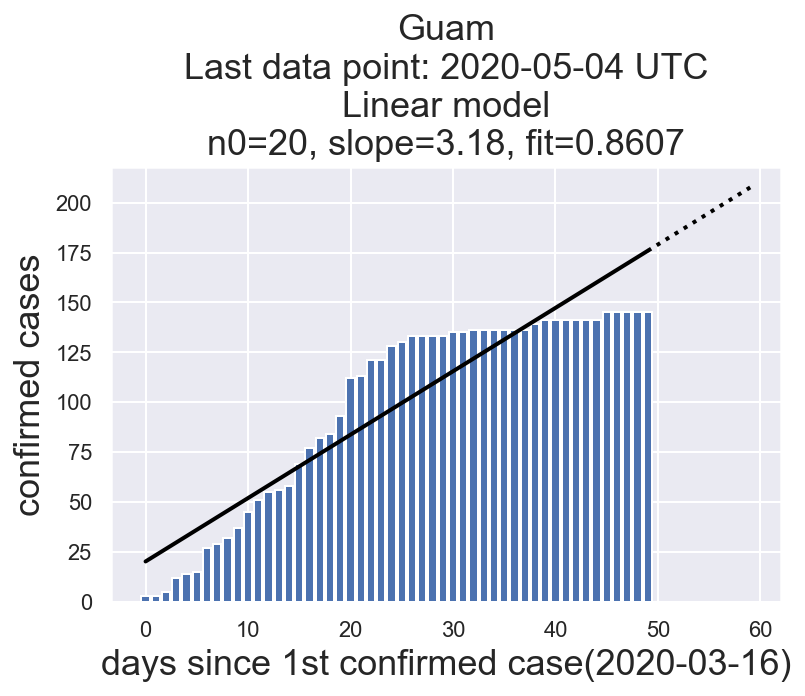

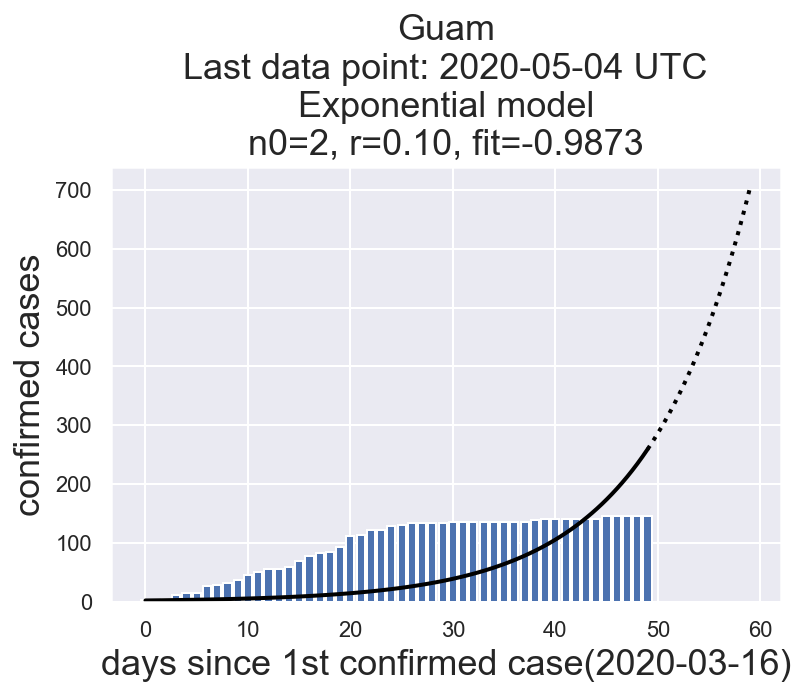

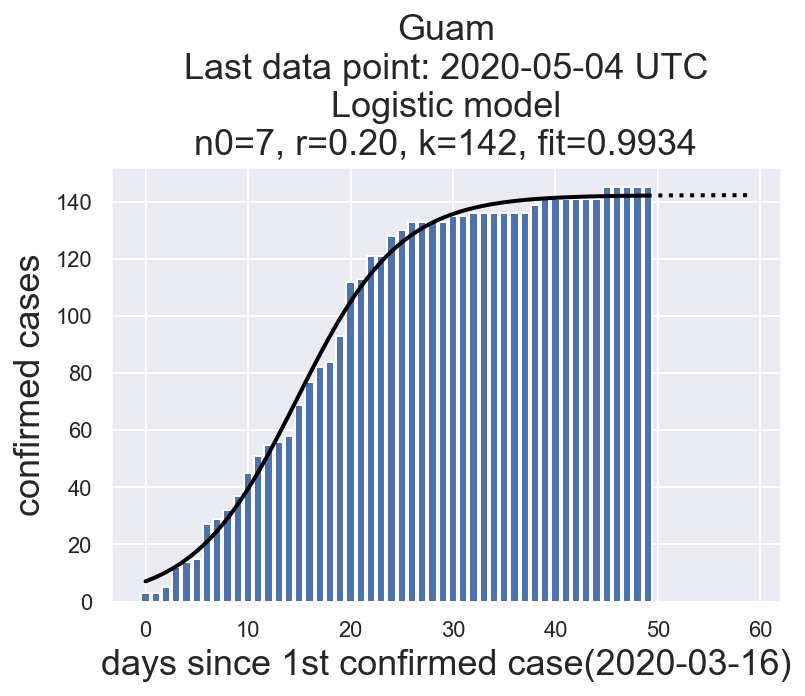

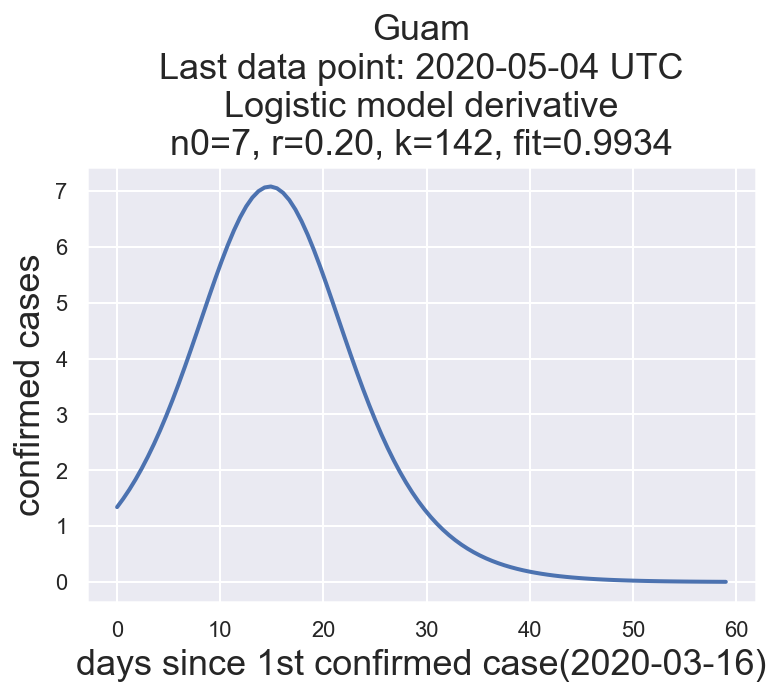

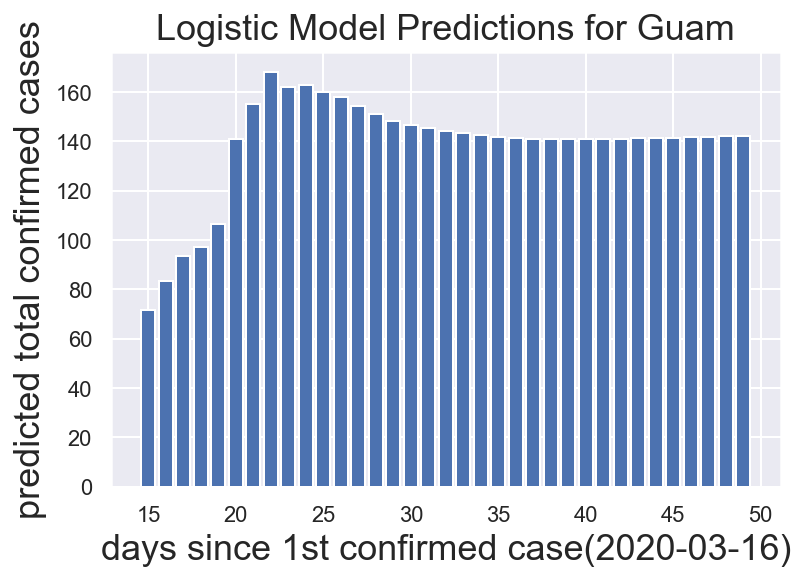

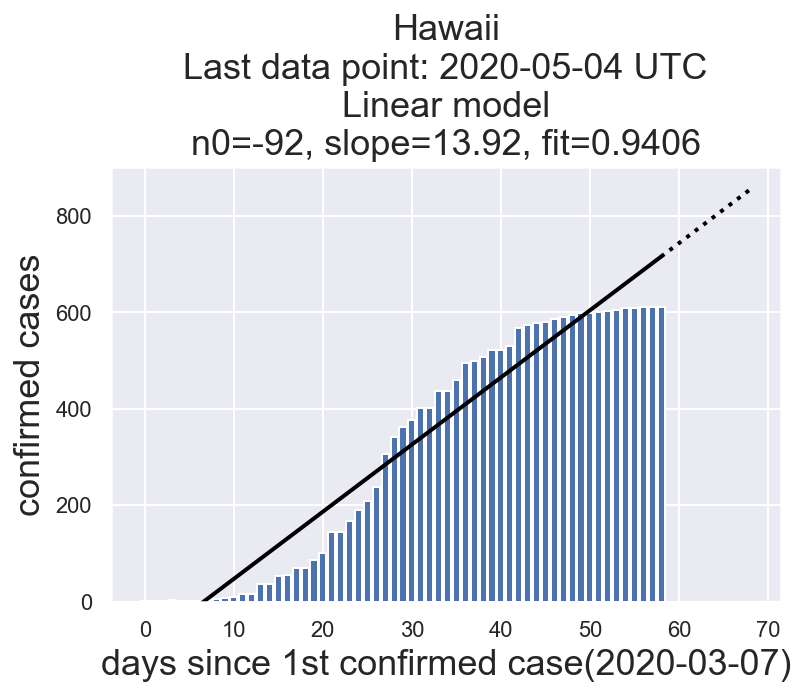

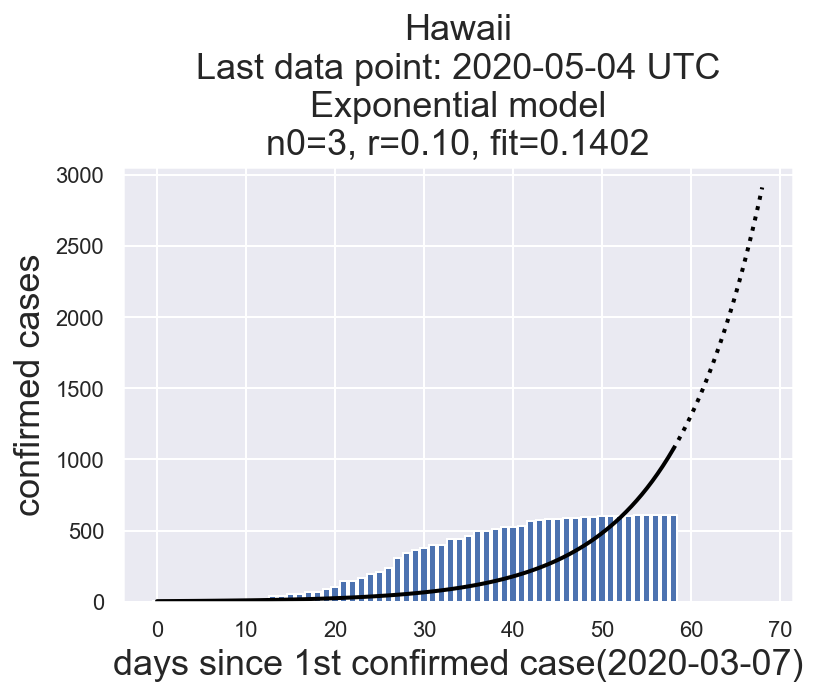

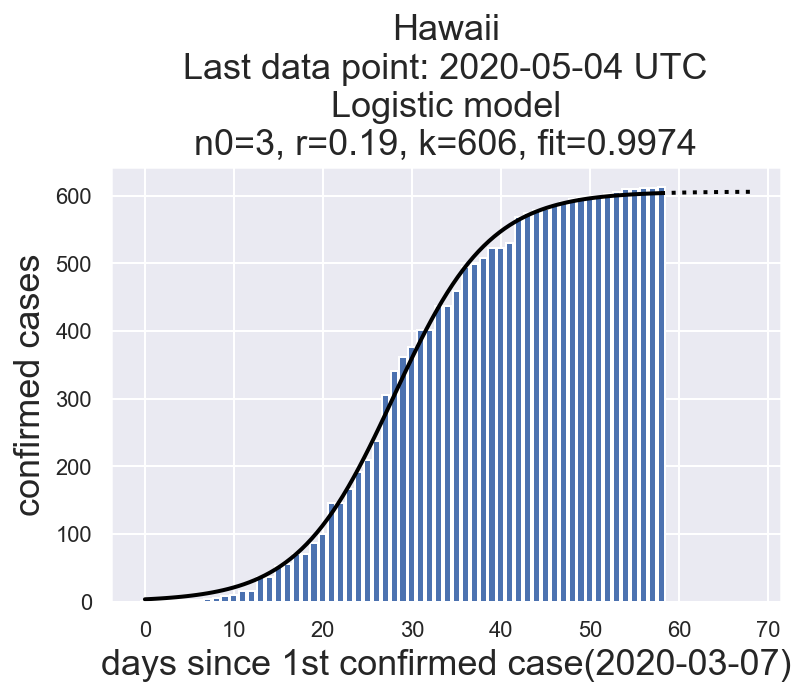

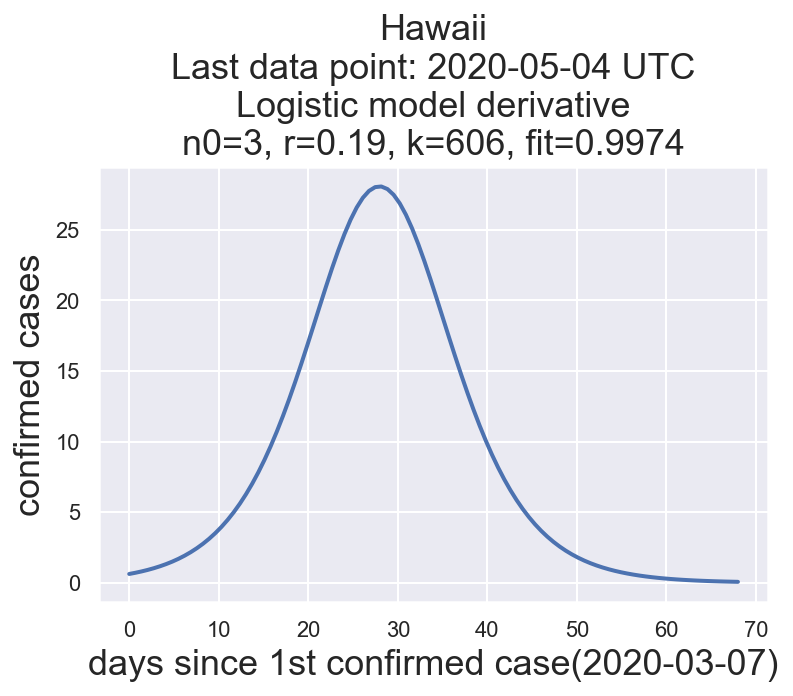

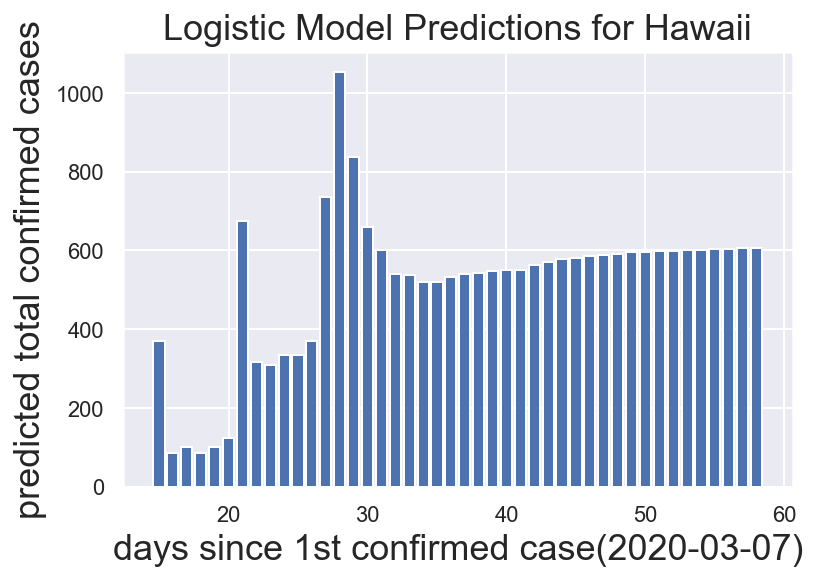

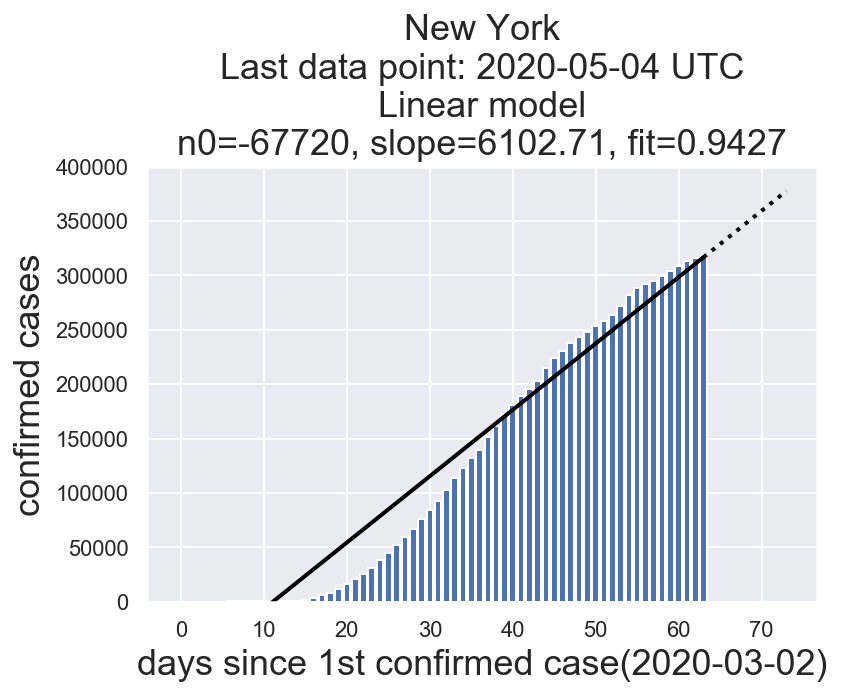

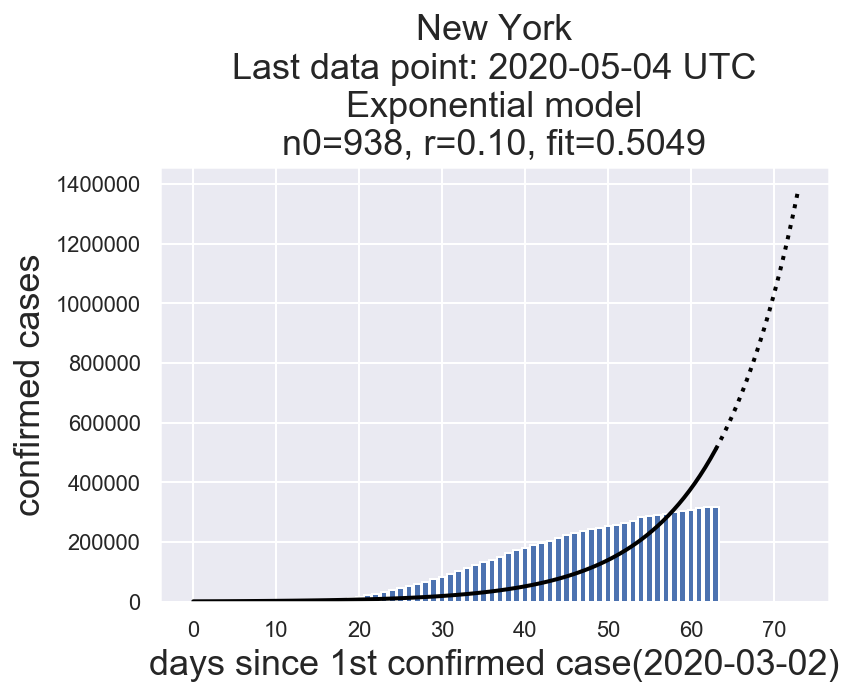

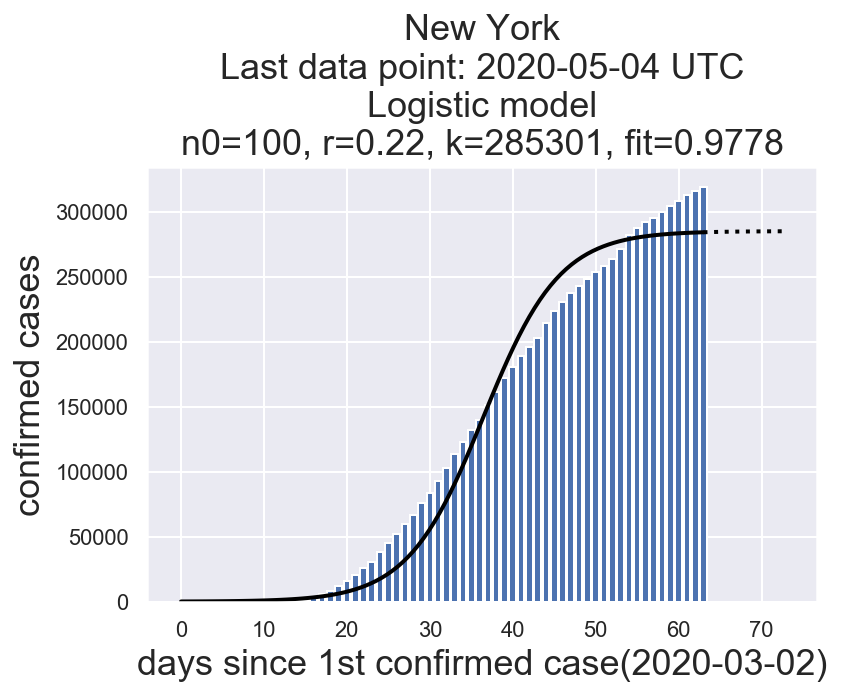

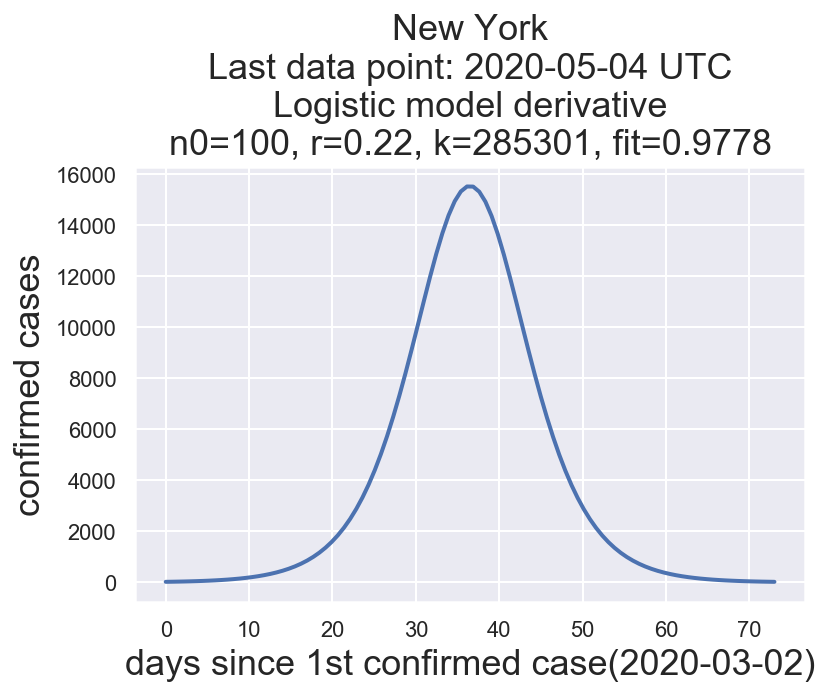

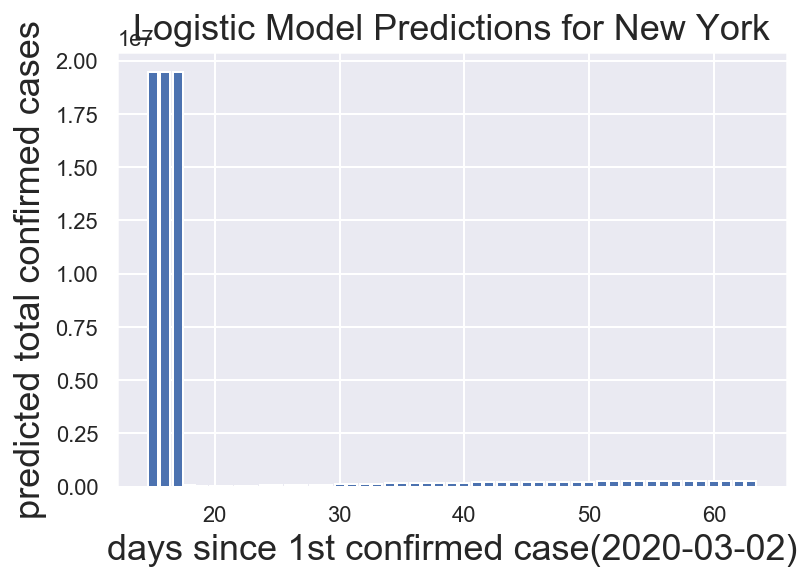

In [8]:
place_names = ['Guam', 'Hawaii', 'New York']
for place_name in place_names:
    df = get_data(place_name)   
    for model in [linear_model, exponential_model, logistic_model]:
        fit_curve(place_name=place_name, 
                  df=df, 
                  model=model, 
                  p0=parameters[place_name][model.__name__]['initial'], 
                  bounds=[parameters[place_name][model.__name__]['lower_bounds'], 
                          parameters[place_name][model.__name__]['upper_bounds']], 
                  extrapolated_days=10)        
    plot_logistic_model_derivative(place_name) 
    logistic_model_predictions(place_name)